In [1]:
!pip install --upgrade --no-cache-dir torch torchvision torchaudio --quiet
!pip install segmentation-models-pytorch --quiet
!pip install torchmetrics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 121.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Import necessary packages
import os
import cv2
import math
import torch
import pickle
from torch import optim, nn
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from skimage.measure import label
from scipy.ndimage import distance_transform_edt
import numpy as np
from tkinter import filedialog
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


cuda


In [ ]:
def create_weight_map(mask, w0=10, sigma=5):
    """
    Create a U-Net-style pixel-wise weight map for binary segmentation.

    Parameters
    ----------
    mask : np.ndarray
        2D array with values {0, 1}, where 1 is the foreground (cell).
    w0 : float
        Maximum weight to assign to borders.
    sigma : float
        Controls how quickly border weight falls off.

    Returns
    -------
    weight_map : np.ndarray
        2D array with the same shape as `mask`, containing pixel-wise weights.
    """
    mask[mask > 0] = 1
    labeled_mask = label(mask, connectivity=1)
    unique_ids = np.unique(labeled_mask)
    unique_ids = unique_ids[unique_ids != 0]  # remove background

    if len(unique_ids) < 2:
        return np.ones_like(mask, dtype=np.float32)

    # Compute distances to the two nearest objects
    distances = np.zeros((len(unique_ids),) + mask.shape, dtype=np.float32)
    for i, obj_id in enumerate(unique_ids):
        binary_other = labeled_mask != obj_id
        distances[i] = distance_transform_edt(binary_other)

    distances = np.sort(distances, axis=0)
    d1, d2 = distances[0], distances[1]

    # Border weight map
    border_weights = w0 * np.exp(-((d1 + d2) ** 2) / (2 * sigma ** 2))

    # Base class weight: foreground and background = 1.0
    weight_map = np.zeros_like(mask, dtype=np.float32)

    # Add border emphasis
    weight_map += border_weights + 0.25

    # de-emphasize the masked regions
    weight_map[labeled_mask != 0] = 2

    # re-emphasize background
    return weight_map



from scipy.ndimage import gaussian_filter, map_coordinates

def elastic_deform(image, mask, weight, alpha=6, sigma=3):
    """
    Apply elastic deformation to a weighted mask and an image.

    Parameters:
    weighted_mask : ndarray
        The input weighted_mask to deform.
    image : ndarray
        The input image to deform.
    alpha : float
        The scaling factor for displacement.
    sigma : float
        The standard deviation for Gaussian smoothing.

    Returns:
    deformed_image : ndarray
        The deformed image.
    """
    shape = mask.shape
    # Generate random displacement field
    random_field = np.random.rand(*shape, 2) * 2 - 1  # Random displacements in x and y
    random_field *= alpha  # Scale by alpha

    # Smooth the displacement field using a Gaussian filter
    smooth_field = gaussian_filter(random_field, sigma=sigma)

    # Map the displacement field onto the original image
    displacements = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    displacements = [displacements[0] + smooth_field[:, :, 0], displacements[1] + smooth_field[:, :, 1]]

    # Apply the displacement to the image using map_coordinates
    deformed_image  = map_coordinates(image, displacements, order=1, mode='nearest')
    deformed_mask   = map_coordinates(mask, displacements, order=1, mode='nearest')
    deformed_weight = map_coordinates(weight, displacements, order=1, mode='nearest')

    return deformed_image, deformed_mask, deformed_weight

In [ ]:
class SegmentationDataset(Dataset):

    def __init__(self, images, masks, crop_size=64):
        """
        Initialize the dataset

        :param images: np.array of [n_images, n_pixels, n_pixels]
        :param masks: np.array of [n_images, n_pixels, n_pixels]
        """
        self.images  = images
        self.masks   = masks
        self.weights = [create_weight_map(self.masks[i]) for i in range(self.masks.shape[0])]
        self.crop    = crop_size

    def __len__(self):
        """
        Returns the number of items in the dataset.

        :return: The size of the dataset.
        """
        return self.images.shape[0]

    def __getitem__(self, index):
        """
        Retrieves an item by its index.

        :param idx: Index of the item to retrieve.
        :return: A tuple containing the image and its label, both possibly transformed.
        """

        # Get base items
        b_image  = self.images[index]
        b_mask   = self.masks[index]
        b_weight = self.weights[index]

        # Generate deformed items
        if np.random.rand() > 0.5:
            d_image, d_mask, d_weight = elastic_deform(b_image, b_mask, b_weight)
        else:
            d_image, d_mask, d_weight = b_image, b_mask, b_weight


        # perform transform
        transform = A.Compose([
            # A.Rotate(limit=45, border_mode=cv2.BORDER_CONSTANT, value=0, p=0.5), # annoying, can't use value of 0
            A.CropNonEmptyMaskIfExists(height=int(self.crop), width=int(self.crop), p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ToTensorV2()],
            additional_targets={'image': 'image', 'mask': 'mask', 'weight': 'mask'})

        # Transform items
        transformed = transform(image=d_image, mask=d_mask, weight=d_weight)

        t_image  = transformed["image"]
        t_mask   = transformed["mask"]
        t_weight = transformed["weight"]

        min_val = torch.min(t_image)
        max_val = torch.max(t_image)
        t_image = (t_image - min_val) / (max_val-min_val)

        min_val = torch.min(t_mask)
        max_val = torch.max(t_mask)
        t_mask = (t_mask - min_val) / (max_val-min_val)

        return t_image.to(torch.float32), t_mask.to(torch.float32).unsqueeze(0), t_weight.to(torch.float32).unsqueeze(0)

    def update_crop(self, crop):
        self.crop = crop

In [ ]:
# Extract base files
with open("pretraining_data.pkl", 'rb') as f:
    images, masks = pickle.load(f)

# extract into train and test sets
train_images, temp_images, train_masks, temp_masks = train_test_split(images, masks, test_size=0.4, random_state=42)

# split train further into train and validation
val_images, test_images, val_masks, test_masks = train_test_split(temp_images, temp_masks, test_size=0.5, random_state=42)  # 0.4 * 0.5 = 0.2

# Create the datasets
train_dataset = SegmentationDataset(train_images, train_masks, crop_size=64)
val_dataset = SegmentationDataset(val_images, val_masks, crop_size=256)
test_dataset = SegmentationDataset(test_images, test_masks, crop_size=256)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Example usage of DataLoader
for _images, _masks, _weights in train_loader:
    print(_images.shape, _masks.shape, _weights.shape)

torch.Size([4, 1, 64, 64]) torch.Size([4, 1, 64, 64]) torch.Size([4, 1, 64, 64])
torch.Size([4, 1, 64, 64]) torch.Size([4, 1, 64, 64]) torch.Size([4, 1, 64, 64])
torch.Size([4, 1, 64, 64]) torch.Size([4, 1, 64, 64]) torch.Size([4, 1, 64, 64])


train_dataset:  12
val_dataset:  4
test_dataset:  4


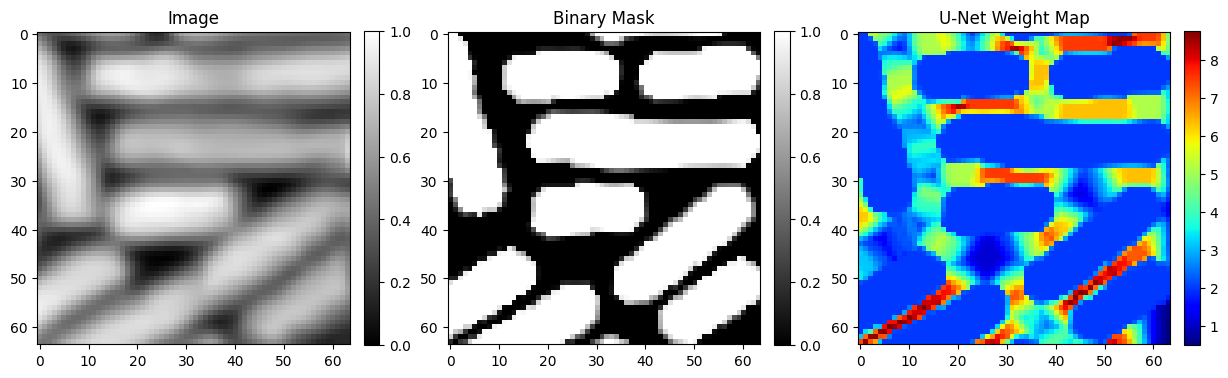

In [ ]:
print("train_dataset: ",len(train_dataset))
print("val_dataset: ",len(val_dataset))
print("test_dataset: ",len(test_dataset))

image0_t, mask0_t, weight0_t = train_dataset[np.random.randint(0, len(train_dataset))]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the image
im0 = axs[0].imshow(image0_t.squeeze(0), cmap='gray')
axs[0].set_title("Image")
# axs[0].axis('off')
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

# Plot the binary mask
im1 = axs[1].imshow(mask0_t.squeeze(0), cmap='gray')
axs[1].set_title("Binary Mask")
# axs[1].axis('off')
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

# Plot the weight map
im2 = axs[2].imshow(weight0_t.squeeze(0), cmap='jet')
axs[2].set_title("U-Net Weight Map")
# axs[2].axis('off')
fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

plt.show()

In [ ]:
# torch.cuda.empty_cache()

**UNET**

In [ ]:
# Define the loss functions
class WeightedBCEWithLogitsLoss(nn.Module):
    def __init__(self, weight_map=None):
        super(WeightedBCEWithLogitsLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='none')  # We use 'none' to calculate per-pixel loss
        self.weight_map = weight_map

    def forward(self, predictions, targets, weight_map=None):
        if weight_map is None:
            weight_map = self.weight_map

        # Compute the pixel-wise loss (element-wise)
        loss = self.bce_loss(predictions, targets)

        # Apply pixel-wise weights
        weighted_loss = loss * weight_map

        # Return the mean weighted loss
        return weighted_loss.mean()  # Or sum if preferred

class WeightedDiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        super(WeightedDiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets, weights):
        # Apply sigmoid to get probabilities
        inputs = torch.sigmoid(inputs)

        # Flatten everything to [B, -1]
        inputs = inputs.view(inputs.size(0), -1)
        targets = targets.view(targets.size(0), -1)
        weights = weights.view(weights.size(0), -1)

        # Apply per-pixel weights to intersection and sums
        intersection = (weights * inputs * targets).sum(dim=1)
        inputs_sum = (weights * inputs).sum(dim=1)
        targets_sum = (weights * targets).sum(dim=1)

        dice = (2. * intersection + self.smooth) / (inputs_sum + targets_sum + self.smooth + 1e-7)

        return 1 - dice.mean()  # Dice Loss


class CombinedWeightedLoss(nn.Module):
    def __init__(self, alpha=0.5, smooth=1.0):
        super(CombinedWeightedLoss, self).__init__()
        self.alpha = alpha  # weight for BCE vs Dice
        self.bce = WeightedBCEWithLogitsLoss()
        self.dice = WeightedDiceLoss(smooth=smooth)

    def forward(self, inputs, targets, weight_map):
        bce_loss = self.bce(inputs, targets, weight_map)
        dice_loss = self.dice(inputs, targets, weight_map)
        return self.alpha * bce_loss + (1 - self.alpha) * dice_loss

In [ ]:
# Calculate pixel accuracy
def accuracy(pred, target):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()

    target = (target > 0.5).float()

    # Ensure shapes match
    if pred.shape != target.shape:
        raise ValueError(f"Shape mismatch: pred {pred.shape}, target {target.shape}")

    correct = (pred == target).float()
    acc = correct.sum() / correct.numel()

    return acc


# Calculate Dice Coefficient
def dice_coefficient(pred, target):
    target = (target > 0.5).float()  # Convert target to binary
    # Flatten both prediction and target
    pred = torch.sigmoid(pred).view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return 2 * intersection / union if union != 0 else 1.0


In [ ]:
# Define the training loop
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    running_dice = 0.0
    total_samples = 0

    for images, masks, weights in train_loader:
        images, masks, weights = images.to(device), masks.to(device), weights.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)

        # Calculate loss (using soft labels and pixel-wise weights)
        loss = criterion(outputs, masks, weight_map=weights)

        # Backward pass
        loss.backward()
        optimizer.step()

        predicted = torch.sigmoid(outputs.detach()) * weights.detach()

        # Calculate accuracy and dice coefficient
        acc = accuracy(predicted, masks)
        dice = dice_coefficient(predicted, masks)

        # Update metrics
        running_loss += loss.item()
        running_accuracy += acc.item()
        running_dice += dice.item()
        total_samples += 1

    # Average loss, accuracy, and dice
    avg_loss = running_loss / total_samples
    avg_accuracy = running_accuracy / total_samples
    avg_dice = running_dice / total_samples

    return avg_loss, avg_accuracy, avg_dice

# Define the evaluation loop
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    running_dice = 0.0
    total_samples = 0

    with torch.no_grad():  # No need to compute gradients during evaluation
        for images, masks, weights in val_loader:
            images, masks, weights = images.to(device), masks.to(device), weights.to(device)

            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, masks, weight_map=weights)

            predicted = torch.sigmoid(outputs).detach() * weights.detach()

            # Calculate accuracy and dice coefficient
            acc = accuracy(predicted, masks)
            dice = dice_coefficient(predicted, masks)

            # Update metrics
            running_loss += loss.item()
            running_accuracy += acc.item()
            running_dice += dice.item()
            total_samples += 1

    # Average loss, accuracy, and dice
    avg_loss = running_loss / total_samples
    avg_accuracy = running_accuracy / total_samples
    avg_dice = running_dice / total_samples

    return avg_loss, avg_accuracy, avg_dice

def linear_crop_scheduler_with_step(start, stop, total_epochs, step_size=32):
    def schedule(epoch):
        # Calculate the target crop size based on a step size of 32
        progress = (epoch / total_epochs) * (stop - start)
        crop_size = int(start + (progress // step_size) * step_size)
        return min(crop_size, stop)  # Ensure the crop size doesn't exceed the stop value
    return schedule

# Training and validation loop
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=500):
    train_loss_array = []
    train_accuracy_array = []
    train_dice_array = []
    val_loss_array = []
    val_accuracy_array = []
    val_dice_array = []

    best_val_loss = float('inf')
    best_val_accuracy = 0.
    best_val_dice = 0.

    patience = 30
    counter  = 0
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):

        # do dataset/loader modifications here
        crop_size = linear_crop_scheduler_with_step(64, 256, num_epochs)(epoch)
        train_dataset.update_crop(crop_size)
        train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

        # Training phase
        train_loss, train_accuracy, train_dice = train_one_epoch(model, train_loader, optimizer, criterion, device)

        # Append metrics to arrays
        train_loss_array.append(train_loss)
        train_accuracy_array.append(train_accuracy)
        train_dice_array.append(train_dice)

        # Validation phase
        val_loss, val_accuracy, val_dice = evaluate(model, val_loader, criterion, device)

        # Add to loss arrays
        val_loss_array.append(val_loss)
        val_accuracy_array.append(val_accuracy)
        val_dice_array.append(val_dice)

        best_val_accuracy = max(best_val_accuracy,  val_accuracy)
        best_val_dice = max(best_val_dice,  val_dice)

        # Print update
        if epoch % 20 == 0:
            # Print out metrics for both training and validation
            print(f"Epoch {epoch+1}/{num_epochs}:")
            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Dice: {train_dice:.4f}")
            print(f"Best Validation Loss: {best_val_loss:.4f}, Best Validation Accuracy: {best_val_accuracy:.4f}, Best Validation Dice: {best_val_dice:.4f}")


        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), "best_pretrained_model.pt")  # save best model
            # print(f"O - Epoch {epoch+1}: improved val_loss to {val_loss:.4f}")
        else:
            counter += 1
            print(f"X - Epoch {epoch+1}: no improvement ({counter}/{patience})")

        if counter >= patience:
            print("Early stopping triggered!")
            break

        scheduler.step()
    return {
        "train_loss_array": train_loss_array,
        "train_accuracy_array": train_accuracy_array,
        "train_dice_array": train_dice_array,
        "val_loss_array": val_loss_array,
        "val_accuracy_array": val_accuracy_array,
        "val_dice_array": val_dice_array
    }

In [3]:
model = smp.Unet(
    encoder_name="resnet50",      # aggressive
    encoder_weights="imagenet",   # Use pretrained weights
    in_channels=1,                # e.g., grayscale
    classes=1                     # binary mask
).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Model Loaded


Pretraining Model:

Epoch 1/500:
Train Loss: 0.8016, Train Accuracy: 0.4443, Train Dice: 0.5501
Best Validation Loss: inf, Best Validation Accuracy: 0.4985, Best Validation Dice: 0.5920
X - Epoch 2: no improvement (1/50)
X - Epoch 5: no improvement (1/50)
X - Epoch 6: no improvement (2/50)
X - Epoch 7: no improvement (3/50)
X - Epoch 9: no improvement (1/50)
X - Epoch 12: no improvement (1/50)
X - Epoch 14: no improvement (1/50)
X - Epoch 15: no improvement (2/50)
X - Epoch 19: no improvement (1/50)
Epoch 21/500:
Train Loss: 0.5676, Train Accuracy: 0.4679, Train Dice: 0.6081
Best Validation Loss: 0.5313, Best Validation Accuracy: 0.5000, Best Validation Dice: 0.6361
X - Epoch 21: no improvement (1/50)
X - Epoch 23: no improvement (1/50)
X - Epoch 25: no improvement (1/50)
X - Epoch 29: no improvement (1/50)
X - Epoch 30: no improvement (2/50)
X - Epoch 31: no improvement (3/50)
X - Epoch 32: no improvement (4/50)
X - Epoch 35: no improvement (1/50)
X - Epoch 37: no impro

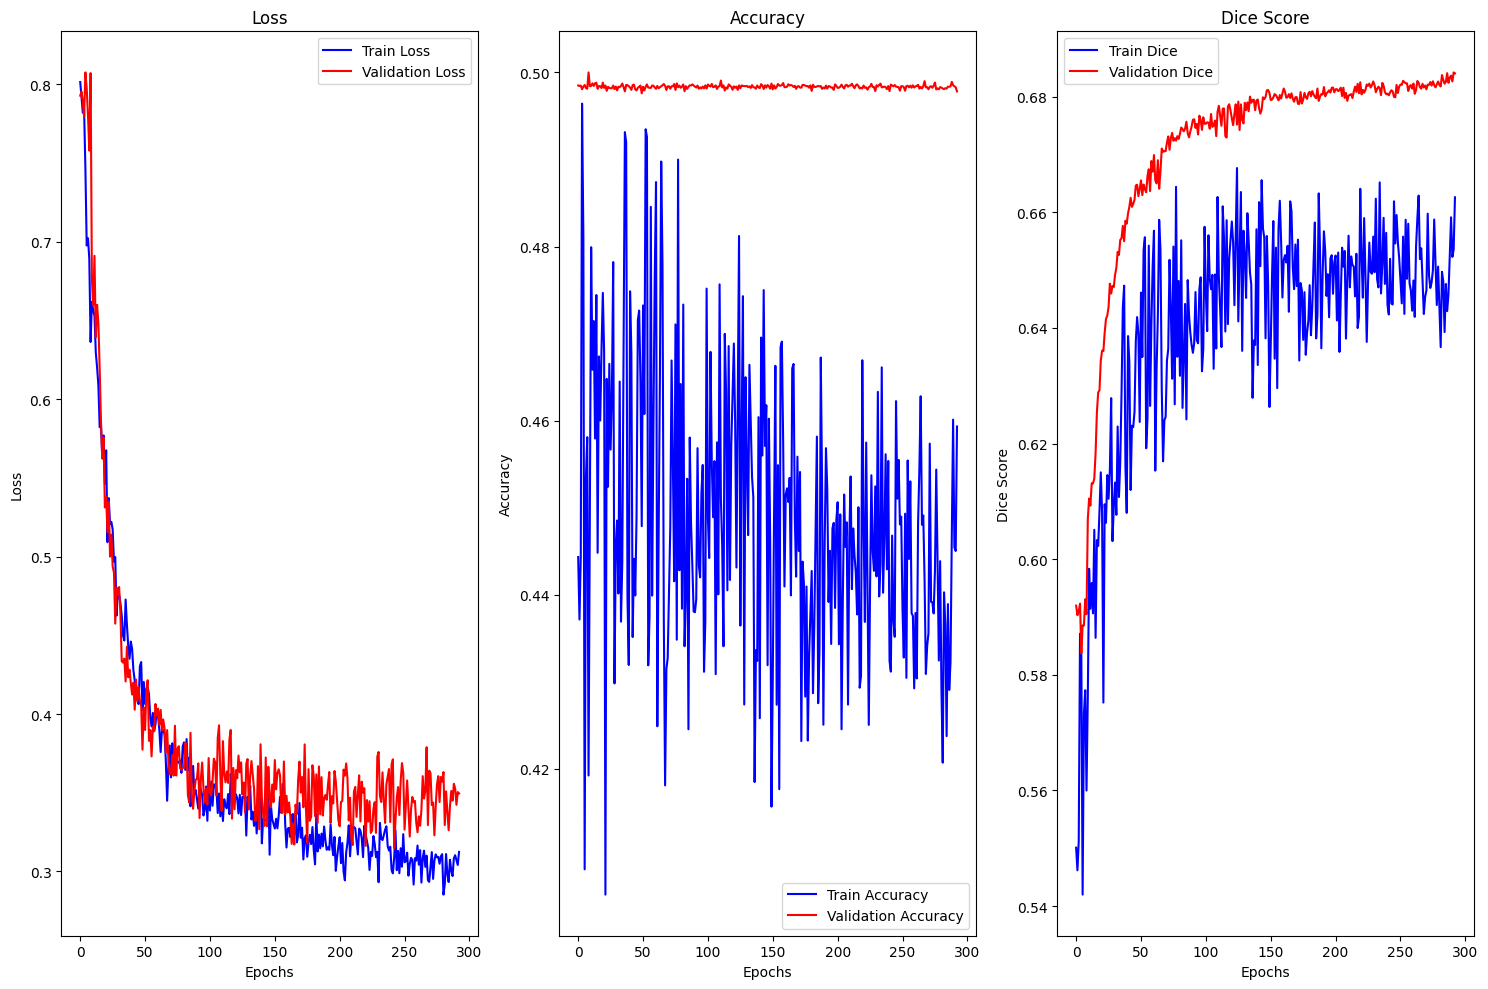

In [ ]:
model = smp.Unet(
    encoder_name="resnet50",      # aggressive
    encoder_weights="imagenet",   # Use pretrained weights
    in_channels=1,                # e.g., grayscale
    classes=1                     # binary mask
).to(device)

print("Model Loaded")

num_epochs = 500

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
criterion = CombinedWeightedLoss(alpha=0.2, smooth=1.0) # alpha is how much BCE Loss is used

print('\n\nPretraining Model:\n')
pretraining_metrics = train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=500)


print("Pretraining Results:")
import matplotlib.pyplot as plt

# Set up the figure for plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

# Plot train and validation loss
axes[0].plot(pretraining_metrics["train_loss_array"], label="Train Loss", color='blue')
axes[0].plot(pretraining_metrics["val_loss_array"], label="Validation Loss", color='red')
axes[0].set_title("Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Plot train and validation accuracy
axes[1].plot(pretraining_metrics["train_accuracy_array"], label="Train Accuracy", color='blue')
axes[1].plot(pretraining_metrics["val_accuracy_array"], label="Validation Accuracy", color='red')
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

# Plot train and validation dice score
axes[2].plot(pretraining_metrics["train_dice_array"], label="Train Dice", color='blue')
axes[2].plot(pretraining_metrics["val_dice_array"], label="Validation Dice", color='red')
axes[2].set_title("Dice Score")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("Dice Score")
axes[2].legend()

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


9


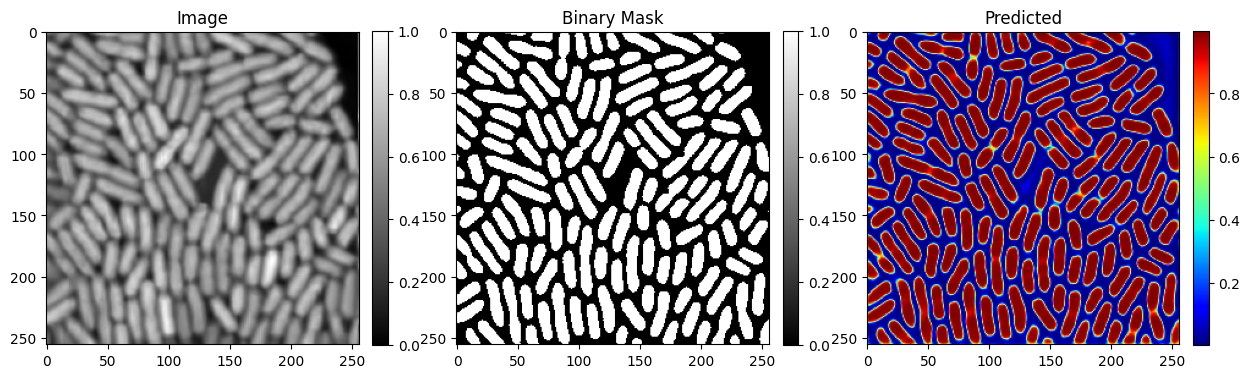

In [ ]:
img_index = np.random.randint(0, len(images))
print(img_index)
# img_index=0
image0_t, mask0_t = images[img_index], masks[img_index]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
image0_t = torch.from_numpy(image0_t)
image0_t = (image0_t-torch.min(image0_t)) / (torch.max(image0_t)-torch.min(image0_t))

predicted = model(image0_t.to(torch.float32).unsqueeze(0).unsqueeze(0).to(device))
predicted = torch.sigmoid(predicted).detach().cpu().squeeze(0).squeeze(0)

# Plot the image
im0 = axs[0].imshow(image0_t, cmap='gray')
axs[0].set_title("Image")
# axs[0].axis('off')
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

# Plot the binary mask
im1 = axs[1].imshow(predicted > 0.5, cmap='gray')
axs[1].set_title("Binary Mask")
# axs[1].axis('off')
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

# Plot the weight map
im2 = axs[2].imshow(predicted, cmap='jet')
axs[2].set_title("Predicted")
# axs[2].axis('off')
fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

plt.show()